## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import math
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

In [2]:
# Function to plot images
def plot_images(images,message):
    no_of_images = len(images)
    rows = math.ceil(math.sqrt(no_of_images))
    columns = math.ceil(math.sqrt(no_of_images))
    fig_img = plt.figure(figsize=(20,16))
    for i in range(no_of_images):
        index = i
        image = images[index]
        a = fig_img.add_subplot(rows,columns,i+1)
        if(len(image.shape)==2):
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(image)
        a.set_title("Image "+str(index+1))
    fig_img.suptitle(message, y=0.1)
    plt.show()

# Camera Calibration

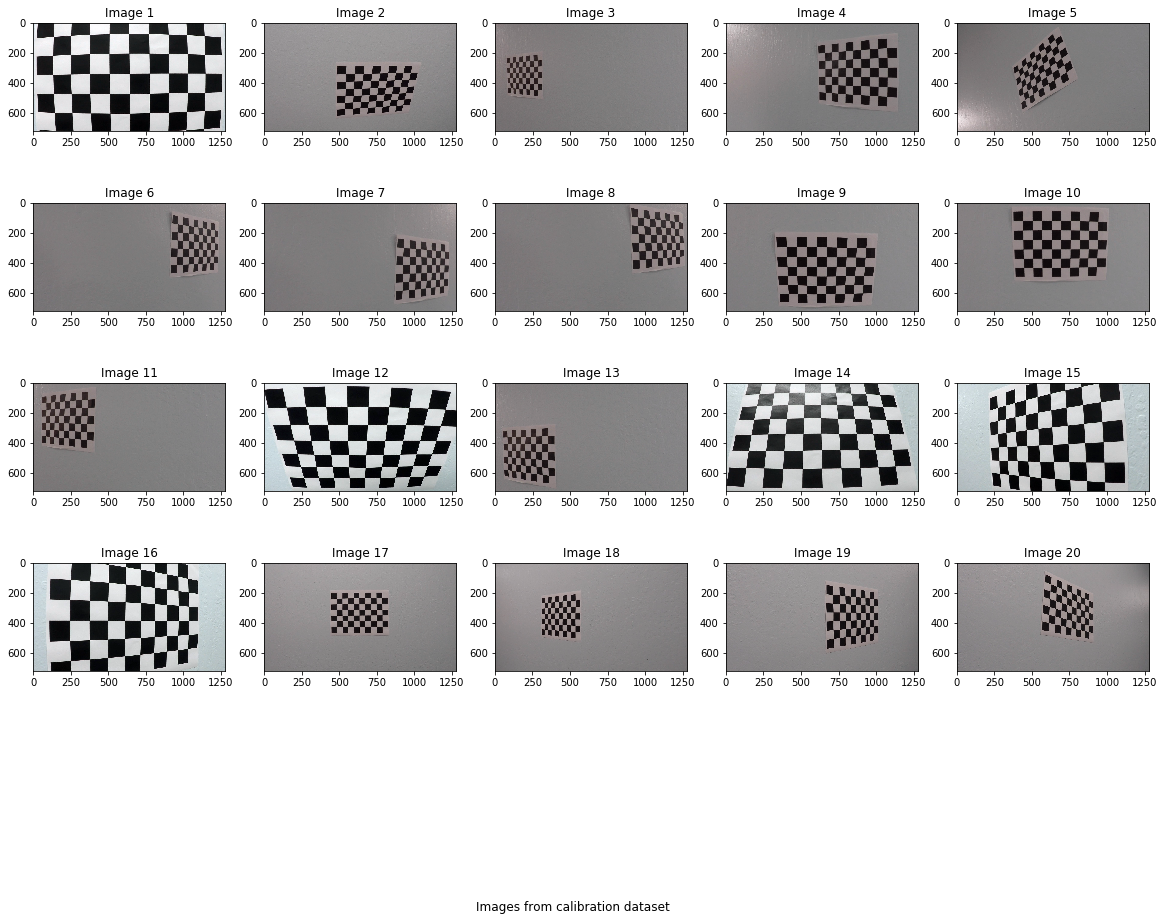


-----------------------------------------------------------------------------------------------------------------------------



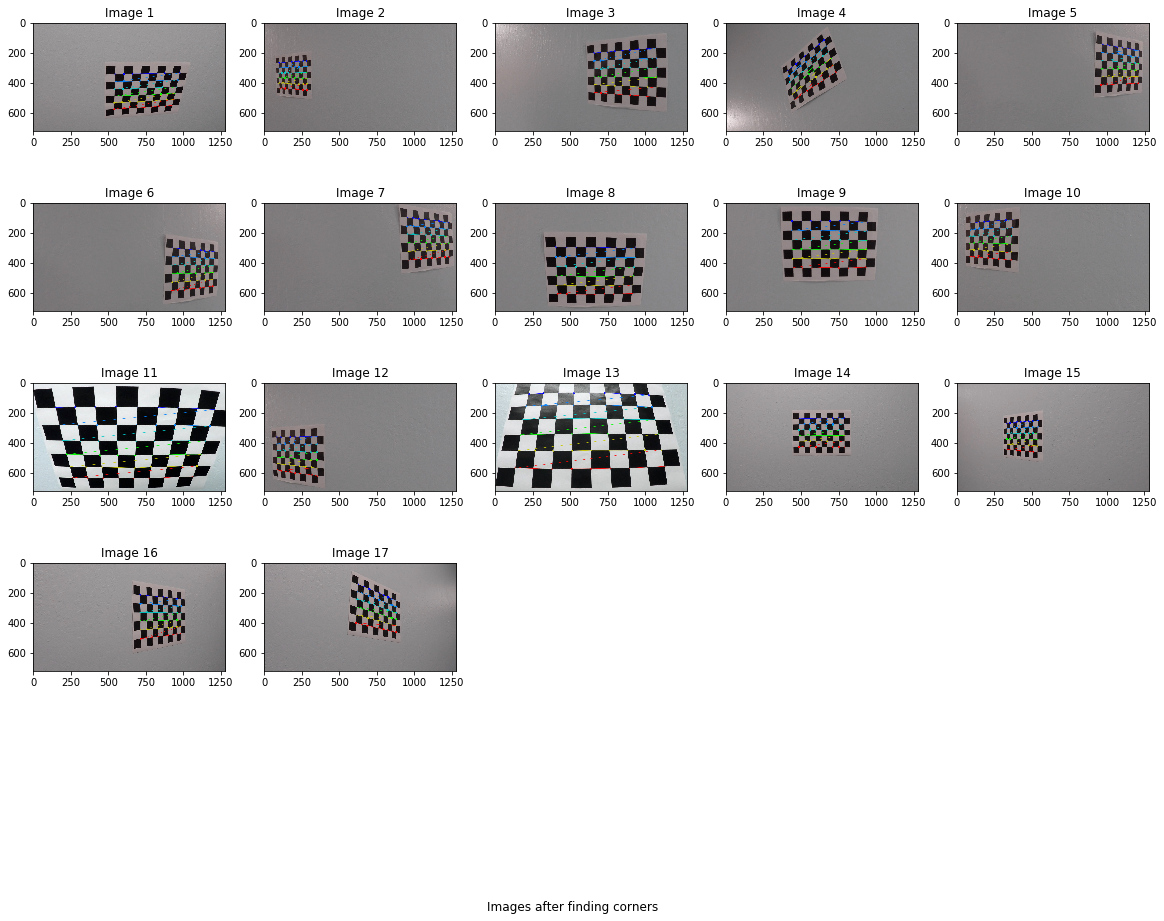

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('.\\camera_cal\\calibration*.jpg')

# Step through the list and search for chessboard corners
uncal_images = [cv2.imread(fname) for fname in images]
plot_images(uncal_images,'Images from calibration dataset')
print("\n-----------------------------------------------------------------------------------------------------------------------------\n")
cal_images = []
for image in uncal_images:
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(image, (9,6), corners, ret)
        cal_images.append(img)

plot_images(cal_images,'Images after finding corners')

In [4]:
def visualize_difference(image_lists, list_names):
    rows = len(image_lists[0])
    columns = len(list_names)
    f, ax_list = plt.subplots(rows, columns, figsize=(24, rows*4))
    for i in range(rows):
        if (str(type(ax_list[i]))=='<class \'numpy.ndarray\'>'):
            r_ax = ax_list[i]
        else:
            r_ax = ax_list
        for j in range(columns):
            img = image_lists[j][i]
            if (list_names[j] != 'Histogram'):
                r_ax[j].imshow(img) if (len(img.shape)!=2) else r_ax[j].imshow(img, cmap='gray')
            else:
                r_ax[j].plot(img)
            if i == 0:
                r_ax[j].set_title(list_names[j])

# Distortion Correction

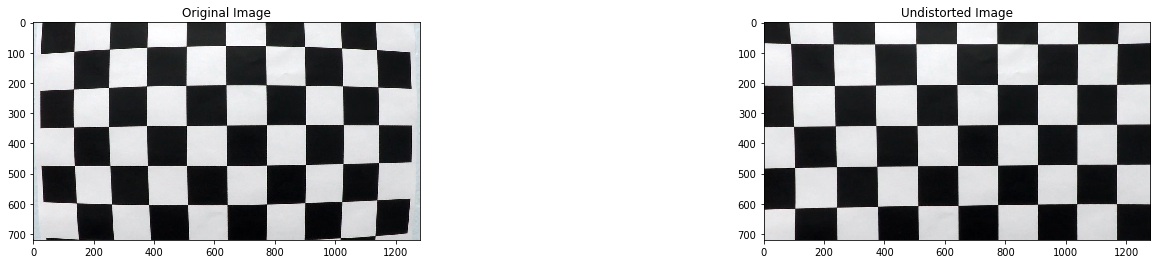

In [5]:
# Testing undistortion on an image
image = uncal_images[0]
img_size = (image.shape[1], image.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
undist = cv2.undistort(image, mtx, dist, None, mtx)

# Plotting the result
visualize_difference([[image], [undist]], ['Original Image', 'Undistorted Image'])

# Saving the calibration matrix and distortion coefficients in pickle for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )

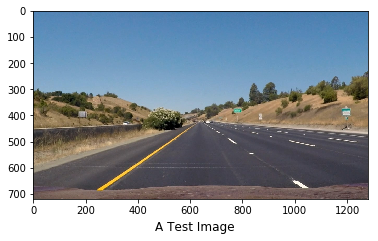

In [6]:
# taking an example image to test the calibration
image = cv2.imread('./test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig = plt.figure()
plt.imshow(image)
fig.suptitle('A Test Image', y=0.1)

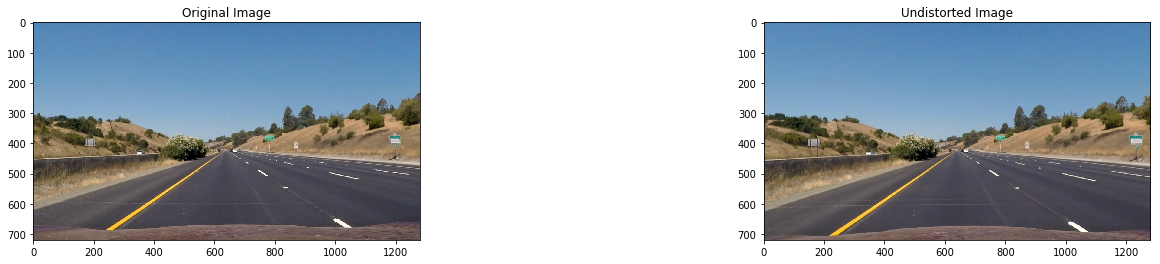

In [7]:
# loading the saved calibration matrix data and distortion coefficients data from pickle
dist_pickle = pickle.load( open( "calibration.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# undistortion function
def undistort(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

# Testing undistortion on the test image
undist = undistort(image)
visualize_difference([[image], [undist]], ['Original Image', 'Undistorted Image'])

# Perspective transform

In [1]:
# warp function
def warp(image):
    img_size = (image.shape[1], image.shape[0])
    w,h = 1280,720
    x,y = 0.5*w, 0.8*h
    src = np.float32([[200./1280*w,720./720*h],[453./1280*w,547./720*h],[835./1280*w,547./720*h],[1100./1280*w,720./720*h]])
    dst = np.float32([[(w-x)/2.,h],[(w-x)/2.,0.82*h],[(w+x)/2.,0.82*h],[(w+x)/2.,h]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped_image = cv2.warpPerspective(image, M, img_size)
    warped_image[:,:300] = 0
    warped_image[:,1150:] = 0
    warped_image[:,500:800] = 0
    return warped_image, Minv

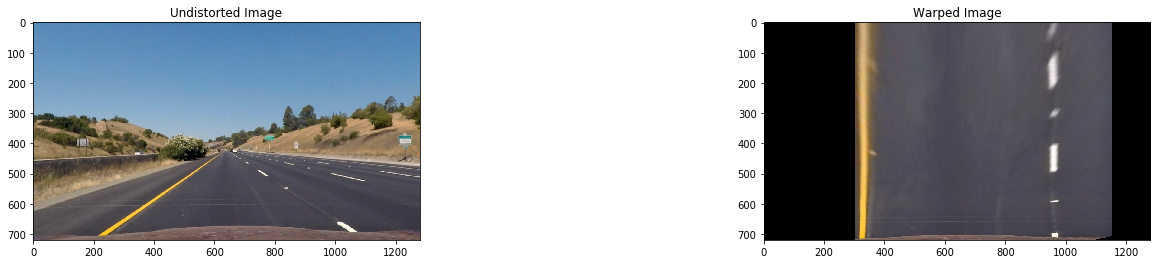

In [9]:
warped_image, Minv = warp(undist)
visualize_difference([[undist], [warped_image]], ['Undistorted Image', 'Warped Image'])

# Color/gradient threshold

In [10]:
# Color/Gradient Thresholding
def threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

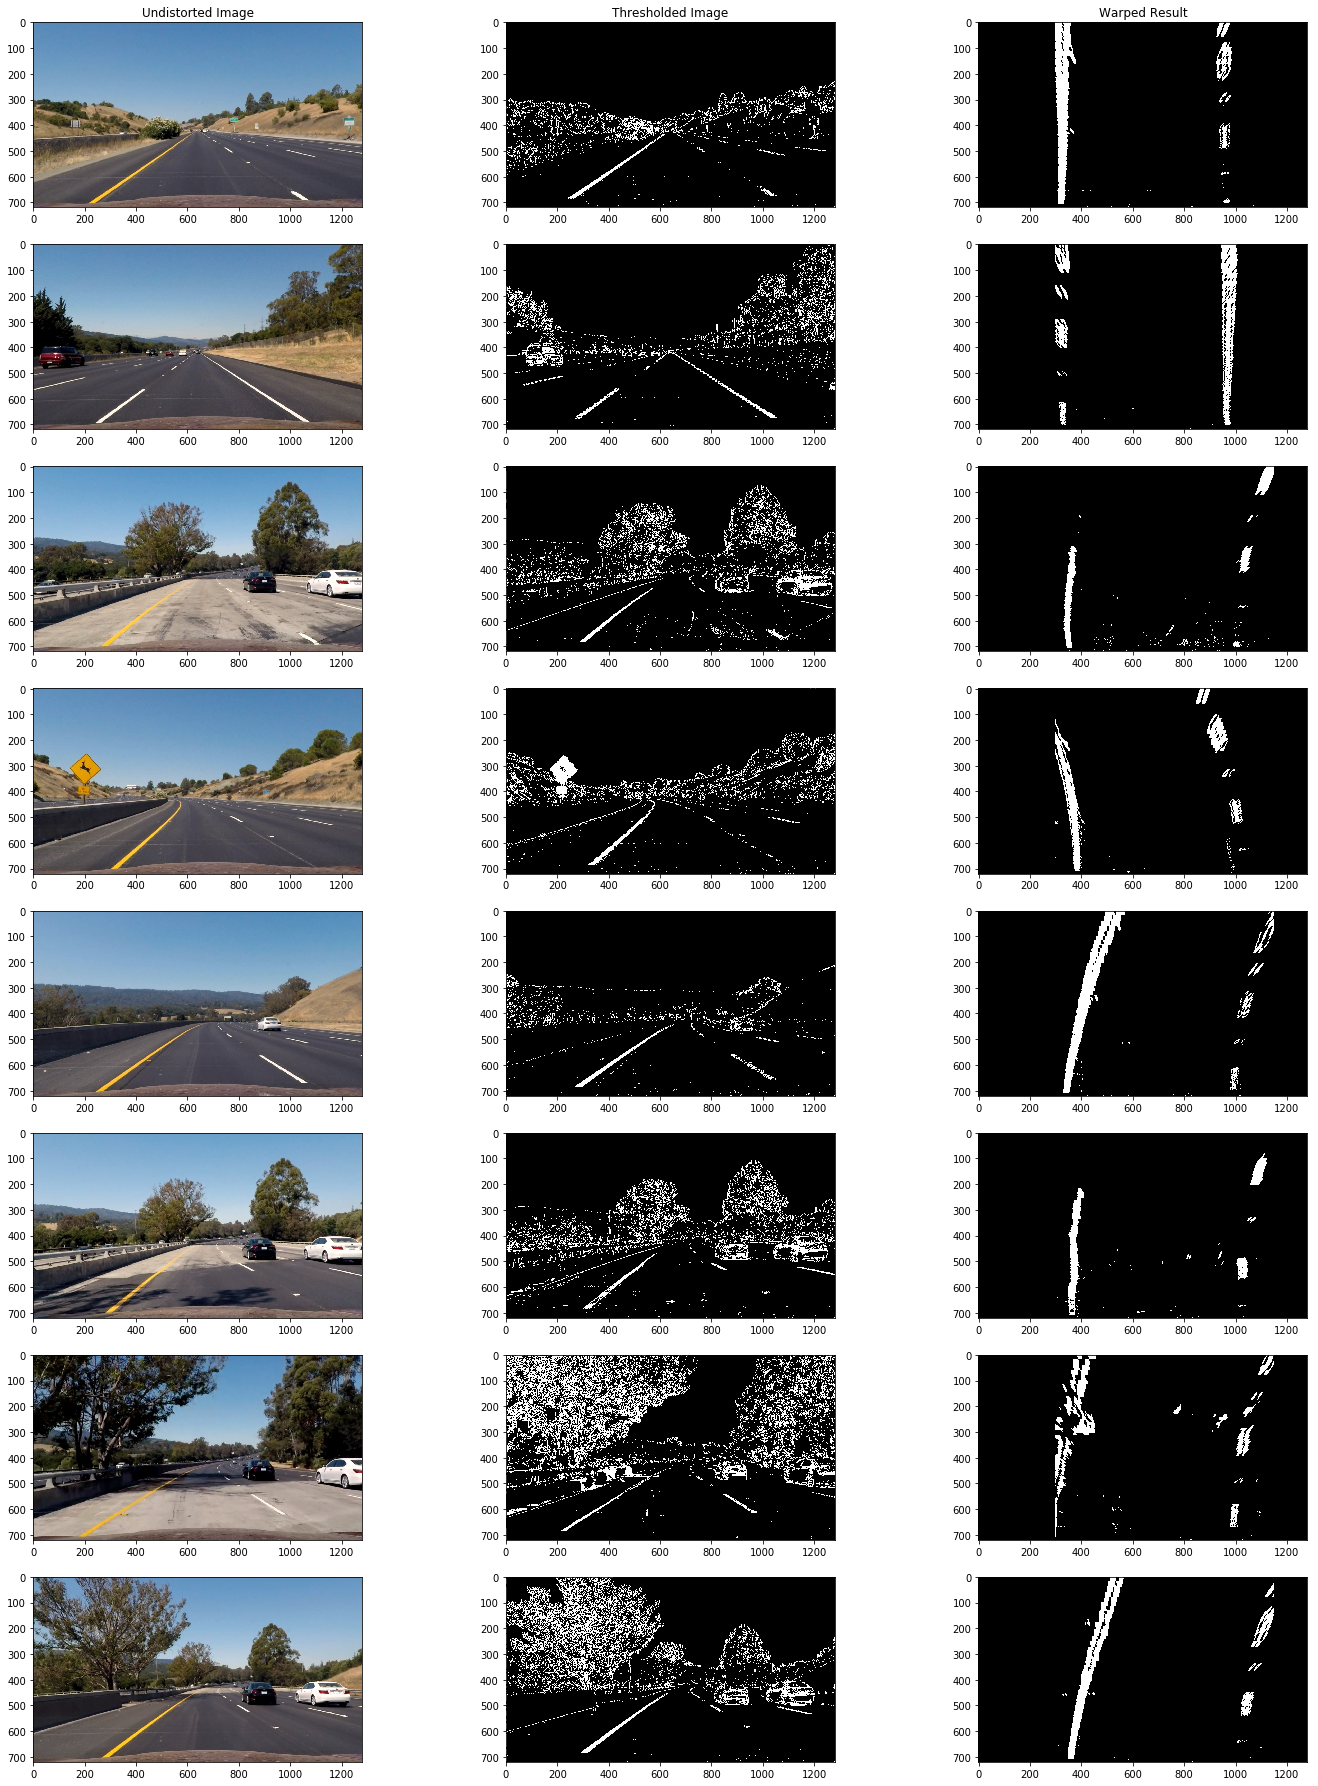

In [11]:
# Make a list of example images
test_images = glob.glob('./test_images/*.jpg')
undist_images = []
thresh_images = []
warped_images = []
for image in test_images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undist_image = undistort(img)
    thresh_image = threshold(img)
    warped_image, Minv = warp(thresh_image)
    undist_images.append(undist_image)
    thresh_images.append(thresh_image)
    warped_images.append(warped_image)
visualize_difference([undist_images, thresh_images, warped_images], ['Undistorted Image','Thresholded Image', 'Warped Result'])

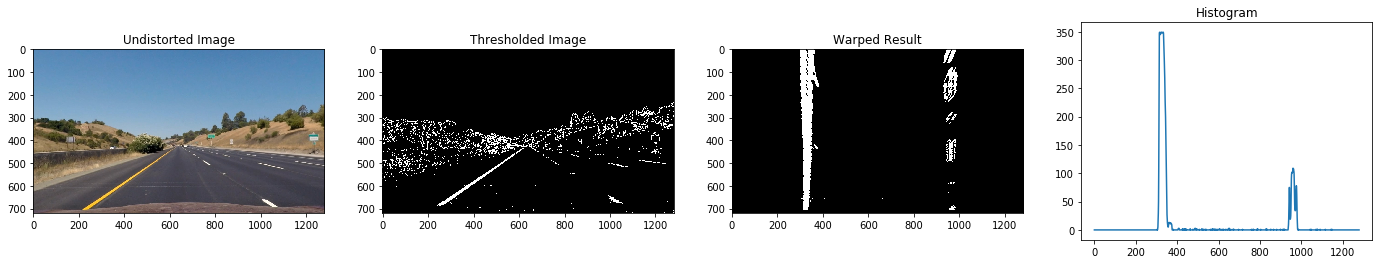

In [12]:
warped_image, Minv = warp(thresh_images[0])
histogram = np.sum(warped_image[warped_image.shape[0]//2:,:], axis=0)
visualize_difference([[undist_images[0]], [thresh_images[0]], [warped_image], [histogram]], ['Undistorted Image','Thresholded Image', 'Warped Result', 'Histogram'])

# Window Fitting

In [13]:
def window_fitting(warped_image):
    # Take a histogram of the bottom half of the image
    binary_warped = warped_image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img,ploty,left_fitx,right_fitx,left_fit,right_fit

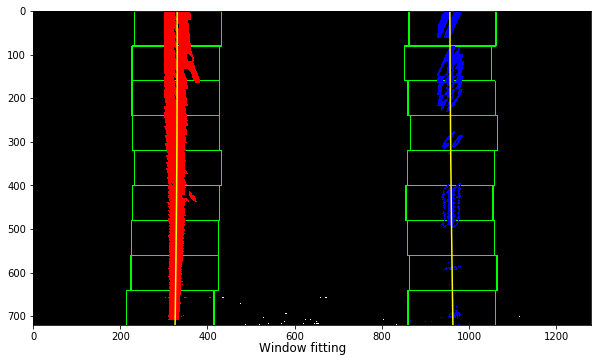

In [14]:
out_img,ploty,left_fitx,right_fitx,left_fit,right_fit = window_fitting(warped_image)
fig = plt.figure(figsize=(10,6))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
fig.suptitle('Window fitting', y=0.1)

In [15]:
def solid_lane(warped_image):
    binary_warped = warped_image
    out_img,ploty,left_fitx,right_fitx,left_fit,right_fit=window_fitting(warped_image)
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return result,ploty,left_fitx,right_fitx,left_fit,right_fit

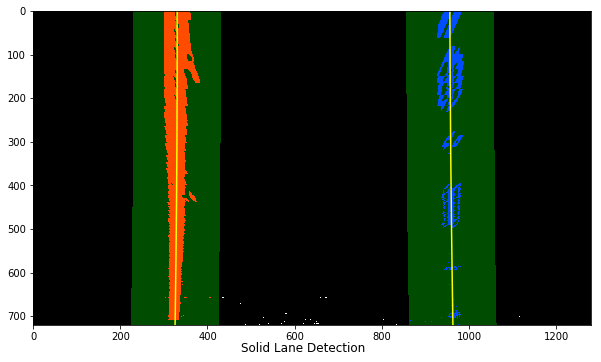

In [16]:
result,ploty,left_fitx,right_fitx,left_fit,right_fit = solid_lane(warped_image)
fig = plt.figure(figsize=(10,6))
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
fig.suptitle('Solid Lane Detection', y=0.1)

In [17]:
def curvature_rad(left_fit):
    ym_per_pix = 3.0/72.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/660.0 # meters per pixel in x dimension
    y_eval = 700
    midx = 650
    
    y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
    y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)

    curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
    return curvature, y_eval, midx, xm_per_pix, ym_per_pix

In [18]:
curvature, y_eval, midx, xm_per_pix, ym_per_pix = curvature_rad(left_fit)
print("Radius of Curvature: %f m" % curvature)

Radius of Curvature: 12730.631187 m


In [19]:
def fit_on_road(undist_img,warped_image,Minv):
    binary_warped = warped_image
    result,ploty,left_fitx,right_fitx,left_fit,right_fit = solid_lane(warped_image)
    curvature, y_eval, midx, xm_per_pix, ym_per_pix = curvature_rad(left_fit)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist_img.shape[1], undist_img.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)

    cv2.putText(result,'Radius of Curvature: %.2fm' % curvature,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

    x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
    x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
    position_from_center = ((x_left_pix + x_right_pix)/2 - midx) * xm_per_pix
    if position_from_center < 0:
        text = 'left'
    else:
        text = 'right'
    cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(position_from_center), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    return result

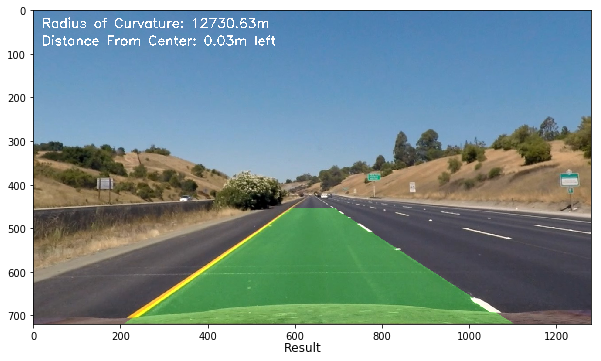

In [20]:
fig = plt.figure(figsize=(10,6))
plt.imshow(fit_on_road(undist_images[0],warped_image,Minv))
fig.suptitle('Result', y=0.1)

# Pipeline

In [21]:
def pipeline(image):
    new_image = np.copy(image)
    undist_image = undistort(new_image)
    thresh_image = threshold(undist_image)
    warped_image,Minv = warp(thresh_image)
    result = fit_on_road(new_image,warped_image,Minv)
    return result

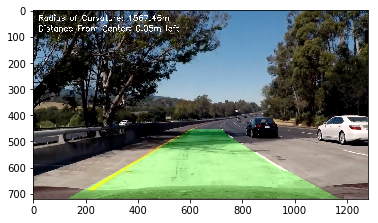

In [22]:
test_image = cv2.imread('./test_images/test5.jpg')
test_image = cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)
image = pipeline(test_image)
plt.imshow(image)

In [23]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'P4.mp4'
video_input = VideoFileClip('project_video.mp4')
processed_video = video_input.fl_image(pipeline)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video P4.mp4
[MoviePy] Writing video P4.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:38<00:00,  5.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: P4.mp4 

Wall time: 3min 40s


In [24]:
video_output2 = 'P4_challenge.mp4'
video_input2 = VideoFileClip('challenge_video.mp4')
processed_video = video_input2.fl_image(pipeline)
%time processed_video.write_videofile(video_output2, audio=False)

[MoviePy] >>>> Building video P4_challenge.mp4
[MoviePy] Writing video P4_challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:20<00:00,  6.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: P4_challenge.mp4 

Wall time: 1min 23s


In [25]:
video_output3 = 'P4_harder_challenge.mp4'
video_input3 = VideoFileClip('harder_challenge_video.mp4')
processed_video = video_input3.fl_image(pipeline)
%time processed_video.write_videofile(video_output3, audio=False)

[MoviePy] >>>> Building video P4_harder_challenge.mp4
[MoviePy] Writing video P4_harder_challenge.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [05:13<00:00,  3.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: P4_harder_challenge.mp4 

Wall time: 5min 16s
